In [287]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import numpy as np

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

In [288]:
# This is the selected county FIPS which will have the prediction created for it
selected_FIPS = 26115

In [289]:
raw_data_folder = '/Users/bryan/Movies/Data For TDI Project/Raw_Data_County_Level'
file_name = 'County_MedianListingPrice_AllHomes.csv'

In [290]:
list_price_df = pd.read_csv(os.path.join(raw_data_folder,file_name),encoding = "ISO-8859-1")
list_price_df.head(1)

,RegionName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,2010-01,2010-02,2010-03,2010-04,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,6,37,1,399000.0,389000.0,398884.0,398500.0,...,675000.0,658800.0,659000.0,660000.0,662050.0,659000.0,649999.0,649900.0,650000.0,665000.0


Create a new feature for full FIPS code

In [291]:
list_price_df['FIPS'] = list_price_df.StateCodeFIPS*1000 + list_price_df.MunicipalCodeFIPS
list_price_df.head(1)

,RegionName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,2010-01,2010-02,2010-03,2010-04,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,FIPS
0,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,6,37,1,399000.0,389000.0,398884.0,398500.0,...,658800.0,659000.0,660000.0,662050.0,659000.0,649999.0,649900.0,650000.0,665000.0,6037


Now drop all columns not containing time-series information, excluding the full FIPS code

In [292]:
list_price_df.drop(columns=['RegionName','State','Metro','StateCodeFIPS','MunicipalCodeFIPS','SizeRank'],
                   inplace=True)
list_price_df.head(1)

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,FIPS
0,399000.0,389000.0,398884.0,398500.0,399000.0,398000.0,395000.0,399000.0,385000.0,375000.0,...,658800.0,659000.0,660000.0,662050.0,659000.0,649999.0,649900.0,650000.0,665000.0,6037


Now split off the FIPS into its own dataframe

In [293]:
FIPS_df = pd.DataFrame(list_price_df.FIPS)
FIPS_df.columns=['FIPS']
FIPS_df.head(1)

,FIPS
0,6037


Drop FIPS from the time-series dataframe

In [294]:
list_price_df.drop(columns='FIPS',inplace=True)
list_price_df.head(1)

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,399000.0,389000.0,398884.0,398500.0,399000.0,398000.0,395000.0,399000.0,385000.0,375000.0,...,675000.0,658800.0,659000.0,660000.0,662050.0,659000.0,649999.0,649900.0,650000.0,665000.0


Now select a county based on a provided FIPS score, this will be provided by the user in the final app

In [295]:
time_series_vec = list_price_df.loc[FIPS_df.FIPS==selected_FIPS]

In [296]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# load dataset
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = time_series_vec.values.flatten()
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
# results = DataFrame()
# results['rmse'] = error_scores
# print(results.describe())
# results.boxplot()
# pyplot.show()

1) Test RMSE: 5234.636


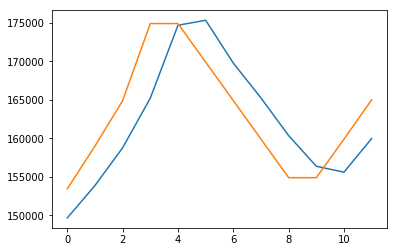

In [297]:
actual_months = list(range(0,len(predictions)))
pred_months = list(range(0,len(predictions)))
plt.plot(pred_months,predictions)
plt.plot(actual_months,time_series_vec.values.flatten()[-12:])
plt.show()

These predictions seem reasonable. We will now choose to use this approach (and model) to predict the following 12 months, which we of course do not have data for

In [298]:
num_months_pred = 12 # Predict 12 months into the future

# Transform data to be stationary
raw_values = time_series_vec.values.flatten()
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(supervised_values)
# Transform into scaled training data
supervised_values = supervised_values.reshape(supervised_values.shape[0], supervised_values.shape[1])
train_scaled = scaler.transform(supervised_values)
test_scaled = [item[0] for item in train_scaled] # Initialize with all data in train

lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
# walk-forward validation on the test data
predictions = [raw_values[-1]]

for i in range(len(train_scaled)-1,len(train_scaled)+num_months_pred):
    # make one-step forecast
    X = numpy.asarray([test_scaled[i]])
    yhat = forecast_lstm(lstm_model, 1, X)
    test_scaled.append(yhat)
    
    # Invert scaling for prediction
    yhat = invert_scale(scaler, X, yhat)
    # Invert differencing for prediction
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # Store the prediction in a separate list
    predictions.append(yhat)

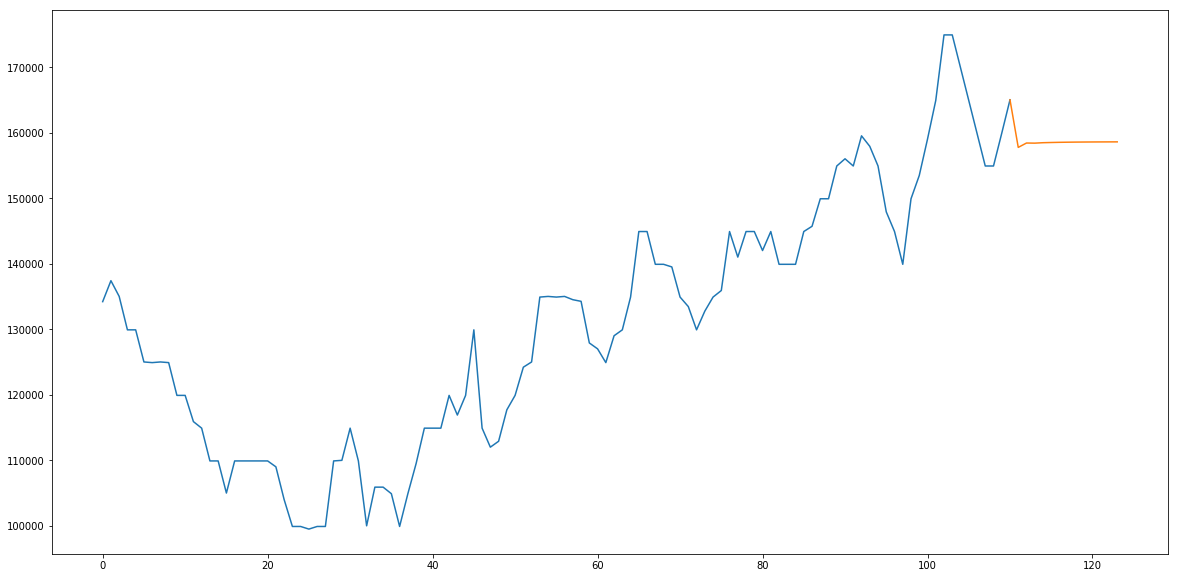

In [299]:
known_months = list(range(0,len(time_series_vec.values.flatten())))
unknown_months = list(range(len(time_series_vec.values.flatten())-1,len(time_series_vec.values.flatten())+13))

plt.figure(figsize=(20,10))
plt.plot(known_months,time_series_vec.values.flatten())
plt.plot(unknown_months,predictions)
plt.show()